In [20]:
import numpy as np
import pandas as pd 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# -*- coding: utf-8 -*-
import random
import math
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model
import h5py
from ann_visualizer.visualize import ann_viz

In [22]:
class TeacherAgent:
    def __init__(self, state_size=4, action_size=3):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.moves_since_hint = 0
        self.not_yet_rewarded = []

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if self.moves_since_hint == 2: #Meaning the teacher waits at most 3 moves for a reward, could be tweaked
            self.moves_since_hint = 0
            return 2 #This enforces that we don't go too long without giving hints (could change to full OR partial hint l8r)
        if np.random.rand() <= self.epsilon:
            random_index = random.randrange(self.action_size)
            if random_index == 0:
                self.moves_since_hint += 1
            else:
                self.moves_since_hint = 0
            return random_index
        act_values = self.model.predict(state)
        nonrandom_index = np.argmax(act_values[0])  # returns action
        if nonrandom_index == 0:
            self.moves_since_hint += 1
        else:
            self.moves_since_hint = 0
        return nonrandom_index

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, int(batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            # if not done: #USED TO BE COMMENTED IN
            #print ("teacher agent state (should be an array with shape (4, )): ", next_state)
            # target = (reward + self.gamma *
            #           np.amax(self.model.predict(next_state)[0]))
            whole_list = self.model.predict(next_state)
            amax_result = np.amax(whole_list[0])
            target = reward + self.gamma * amax_result
            # tabbed over part above

            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [23]:
teacher_agent = TeacherAgent()

In [24]:
print(teacher_agent.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 75        
Total params: 795
Trainable params: 795
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
plot_model(teacher_agent.model, to_file='teacher_model_plot.png', show_shapes=True, show_layer_names=True)

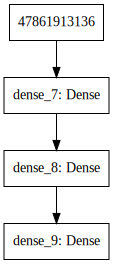

In [28]:
SVG(model_to_dot(teacher_agent.model).create(prog='dot', format='svg'))

In [27]:
ann_viz(teacher_agent.model, title="My second neural network", view=True, filename = 'teacher.gv')

/Users/megumisano/anaconda/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 88060 is still running
  ResourceWarning, source=self)
/Users/megumisano/anaconda/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 88065 is still running
  ResourceWarning, source=self)
/Users/megumisano/anaconda/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 88069 is still running
  ResourceWarning, source=self)
